#### <b>Download the Original Datasets</b>

* <b>CelebA-HQ Dataset</b>: A dataset consisting of 30,000 "human face" images.
    * This dataset has approximately 3GB of data in size and is one of the most widely used face datasets worldwide.
* <b>CelebA-HQ Identity Dataset</b>: A dataset that provides information about <b>who the individuals (subjects) are</b> for each facial image file.
* <b>CelebA-HQ Attribute Dataset</b>: A dataset that provides attribute information for each facial image file.
    * This attribute information includes <b>gender</b>, <b>smiling</b>, and <b>age</b>, which we will be used for a multi-label task.

In [1]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eb37jNPPA7hHl0fmktYqcV8B-qmPLx-ZKYQ1eFk4UPBV_A?download=1 -O CelebAMask-HQ.zip
!wget https://postechackr-my.sharepoint.com/:t:/g/personal/dongbinna_postech_ac_kr/EVRoUY8_txRFv56-KWvZrksBDWbD6adkjBxwwRN7qAC6bg?download=1 -O CelebA-HQ-identity.txt
!wget https://postechackr-my.sharepoint.com/:t:/g/personal/dongbinna_postech_ac_kr/EVrdIrPOkR1OlEWBVK8lE3AB9bFh741GnKBkNgPa8trNuA?download=1 -O CelebA-HQ-attribute.txt

--2023-11-03 15:13:31--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eb37jNPPA7hHl0fmktYqcV8B-qmPLx-ZKYQ1eFk4UPBV_A?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/datasets/CelebAMask-HQ/CelebAMask-HQ.zip?ga=1 [following]
--2023-11-03 15:13:32--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/datasets/CelebAMask-HQ/CelebAMask-HQ.zip?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 3153930546 (2.9G) [application/x-zip-compressed]
Saving to: ‘CelebAMask-HQ.zip’

CelebAMask-HQ.zip   100%[===================>]   2.94G  19.0MB/s    in

In [2]:
%%capture
!rm -rf ./CelebAMask-HQ
!unzip CelebAMask-HQ.zip

#### <b>Load Libraries</b>

* Load various useful python libraries for the experiments.

In [1]:
import os
import time
import random
import glob
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import linear_model, model_selection

In [2]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def compute_losses(net, loader):
    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, labels in loader:
        targets = labels
        inputs, targets = inputs.cuda(), targets.cuda()

        logits = net(inputs)

        losses = criterion(logits, targets).cpu().detach().numpy()
        #losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )


def cal_mia(model):

    set_seed(42)

    forget_losses = compute_losses(model, forget_dataloader_test)
    unseen_losses = compute_losses(model, unseen_dataloader)

    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[: len(unseen_losses)]

    samples_mia = np.concatenate((unseen_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(unseen_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia)
    forgetting_score = abs(0.5 - mia_scores.mean())

    return {'MIA': mia_scores.mean(), 'Forgeting Score': forgetting_score}


@torch.no_grad()
def evaluation(model, data_loader):
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in data_loader:
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = model(inputs)  # Use the passed model argument here
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Use data_loader's dataset length for normalization
        epoch_loss = running_loss / len(data_loader.dataset)
        epoch_loss = round(epoch_loss, 3)
        epoch_acc = running_corrects.item() / len(data_loader.dataset)

        return {'Loss': epoch_loss, 'Acc': epoch_acc}

#### <b>Load Identity Mapping</b>
* Check which person each file name is associated with.
* There are a total of 6,217 individuals (subjects) among the 30,000 files.

In [3]:
path = "./"

In [4]:
identities = {}

# (Image File Name, Subject Identity Information)
with open(path + 'CelebA-HQ-identity.txt') as f:
    lines = f.readlines()
    for line in lines:
        file_name, identity = line.strip().split()
        identities[file_name] = identity

print(f'There are {len(set(identities.values()))} identities.')
print(f'There are {len(identities.keys())} images.')

There are 6217 identities.
There are 30000 images.


#### <b>Choose Single Label to Use</b>
* "male": 21,
* "smiling": 32,
* "young": 40

In [6]:
label_map = {}

label_num = 40  # "male": 21, "smiling": 32, "young": 40

with open(path + 'CelebA-HQ-attribute.txt') as f:
    lines = f.readlines()
    for line in lines[2:]:
        splited = line.strip().split()
        file_name, label = splited[0], splited[label_num]
        label_map[file_name] = label

print(f'There are {len(set(label_map.values()))} classes.')
print(f'There are {len(label_map.keys())} images.')

There are 2 classes.
There are 30000 images.


#### <b>Split the Dataset</b>
* <b>Training dataset  $\mathcal{D}_{train}$</b>: 25,933 images.
* <b>Test dataset $\mathcal{D}_{test}$</b>: 2,065 images.
* <b>Unseen dataset $\mathcal{D}_{unseen}$</b>: 2,002 images.

In [7]:
source_root = path + 'CelebAMask-HQ/CelebA-HQ-img/'

train_index = 190
retain_index = 1250
unseen_index = 4855

In [8]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity >= train_index and identity < unseen_index:
                label = int(label_map[file_name])
                if label == -1: label = 0
                self.labels.append((label, identity))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label[0])

        return image, label

In [9]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []
        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < train_index:
                label = int(label_map[file_name])
                if label == -1: label = 0
                self.labels.append((label, identity))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label[0])

        return image, label

In [10]:
class ForgetDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity >= train_index and identity < retain_index:
                label = int(label_map[file_name])
                if label == -1: label = 0
                self.labels.append((label, identity))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label[0])

        return image, label

In [11]:
class RetainDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < unseen_index and identity >= retain_index:
                label = int(label_map[file_name])
                if label == -1: label = 0
                self.labels.append((label, identity))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label[0])

        return image, label

In [12]:
class UnseenDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []
        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < unseen_index:
                continue
            label = int(label_map[file_name])
            if label == -1: label = 0
            self.labels.append((label, identity))
            self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label[0])

        return image, label

In [13]:
train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

unseen_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

train_set = TrainDataset(transform=train_transform)
test_set = TestDataset(transform=test_transform)
forget_set_train = ForgetDataset(transform=train_transform)
forget_set_test = ForgetDataset(transform=test_transform)
retain_set_train = RetainDataset(transform=train_transform)
retain_set_test = RetainDataset(transform=test_transform)
unseen_set = UnseenDataset(transform=unseen_transform)

In [14]:
print('Train dataset size:', len(train_set))
print('Test dataset size:', len(test_set))
print('Forget dataset size:', len(forget_set_train))
print('Retain dataset size:', len(retain_set_train))
print('Unseen dataset size:', len(unseen_set))

Train dataset size: 25846
Test dataset size: 2053
Forget dataset size: 10135
Retain dataset size: 15711
Unseen dataset size: 2001



* In the NeurIPS Competition setting, when performing machine unlearning, training is done with 'retain' and 'forget', so augmentation can be applied. However, it should never be applied during evaluation.

In [15]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
forget_dataloader_train = torch.utils.data.DataLoader(forget_set_train, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
forget_dataloader_test = torch.utils.data.DataLoader(forget_set_test, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
retain_dataloader_train = torch.utils.data.DataLoader(retain_set_train, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
retain_dataloader_test = torch.utils.data.DataLoader(retain_set_test, batch_size=64, shuffle=False, num_workers=2,pin_memory=True)
unseen_dataloader = torch.utils.data.DataLoader(unseen_set, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [16]:
train_image_paths = TrainDataset().image_paths
test_image_paths = TestDataset().image_paths
forget_image_paths = ForgetDataset().image_paths
retain_image_paths = RetainDataset().image_paths
unseen_image_paths = UnseenDataset().image_paths

train_test_overlap = len(set(train_image_paths) & set(test_image_paths))
train_forget_overlap = len(set(train_image_paths) & set(forget_image_paths))
train_retain_overlap = len(set(train_image_paths) & set(retain_image_paths))
train_unseen_overlap = len(set(train_image_paths) & set(unseen_image_paths))
test_forget_overlap = len(set(test_image_paths) & set(forget_image_paths))
test_retain_overlap = len(set(test_image_paths) & set(retain_image_paths))
test_unseen_overlap = len(set(test_image_paths) & set(unseen_image_paths))
forget_retain_overlap = len(set(forget_image_paths) & set(retain_image_paths))
forget_unseen_overlap = len(set(forget_image_paths) & set(unseen_image_paths))
retain_unseen_overlap = len(set(retain_image_paths) & set(unseen_image_paths))

overlap_dict = {
    'train_test': train_test_overlap,
    'train_forget': train_forget_overlap,
    'train_retain': train_retain_overlap,
    'train_unseen': train_unseen_overlap,
    'test_forget': test_forget_overlap,
    'test_retain': test_retain_overlap,
    'test_unseen': test_unseen_overlap,
    'forget_retain': forget_retain_overlap,
    'forget_unseen': forget_unseen_overlap,
    'retain_unseen': retain_unseen_overlap
}
overlap_dict

{'train_test': 0,
 'train_forget': 10135,
 'train_retain': 15711,
 'train_unseen': 0,
 'test_forget': 0,
 'test_retain': 0,
 'test_unseen': 0,
 'forget_retain': 0,
 'forget_unseen': 0,
 'retain_unseen': 0}

#### <b>Imgae Visualization</b>

In [17]:
if label_num == 21:
    label_convert = {0: "F", 1: "M"}
elif label_num == 32:
    label_convert = {0: "unsmiling", 1: "smiling"}
if label_num == 40:
    label_convert = {0: "old", 1: "young"}

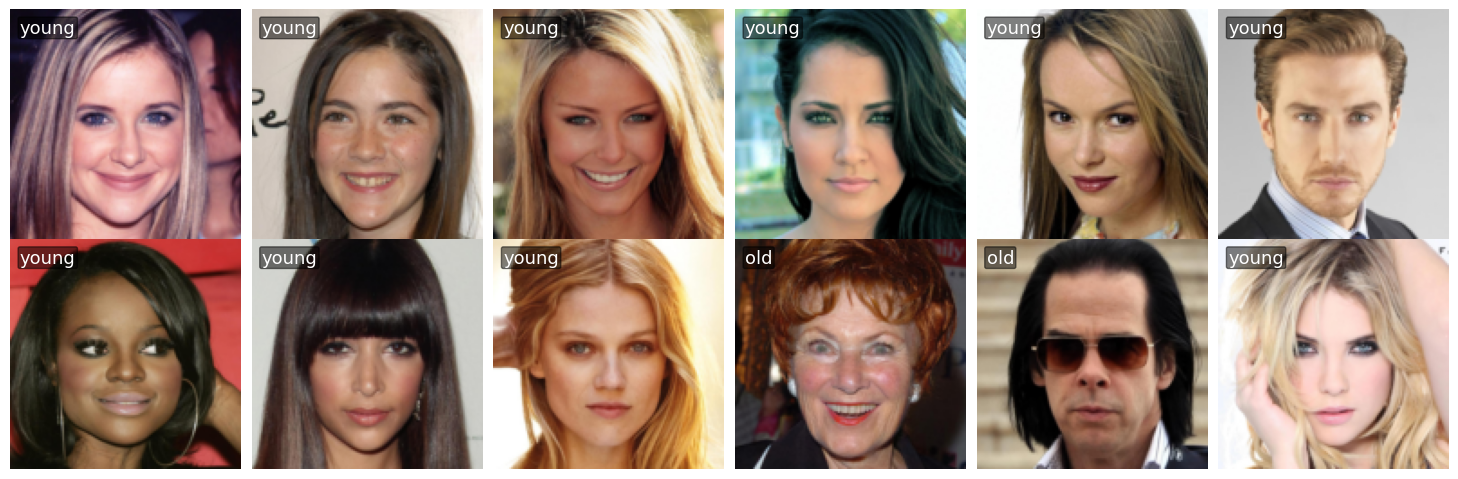

In [18]:
def show_images(images, labels, nrow=6, save_path=None):
    n_images = len(images)
    nrows = n_images // nrow + (n_images % nrow > 0)

    fig, axs = plt.subplots(nrows, nrow, figsize=(14.5, 2.3 * nrows), frameon=False)
    axs = axs.flatten() if n_images > 1 else [axs]

    for idx, (img, label) in enumerate(zip(images, labels)):
        ax = axs[idx]
        img_np = img.numpy().transpose((1, 2, 0))
        ax.imshow(img_np)
        ax.axis('off')

        ax.text(5, 5, label, color='white', fontsize=13,  ha='left', va='top',
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.1'))

    plt.tight_layout(pad=0)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

iterator = iter(test_dataloader)
imgs, labels = next(iterator)

label_strs = [label_convert[label.item()] for label in labels[0:12]]

show_images(imgs[0:12], label_strs, nrow=6)

#### <b>Train the "Original Model"</b>

* Train the Original model to serve as the base model for performing Machine Unlearning

In [19]:
learning_rate = 0.01
log_step = 30

model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [20]:
def train(model, dataloader):
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    log_step = 20

    for i, (imgs, labels) in enumerate(dataloader):
        imgs = imgs.cuda()
        labels = labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total += labels.size(0)
        running_loss += loss.item() * imgs.size(0)
        running_corrects += torch.sum(preds == labels)

        if (i + 1) % log_step == 0:
            current_loss = running_loss / total
            current_acc = running_corrects.double() / total
            print(f'[Batch: {i + 1}] running train loss: {current_loss:.4f}, running train accuracy: {current_acc:.4f}')

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    print(f'train loss: {epoch_loss:.4f}, accuracy: {epoch_acc:.4f}')
    print("elapsed time:", time.time() - start_time)
    return epoch_loss, epoch_acc.item()


def test(model, dataloader):
    start_time = time.time()
    print('[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    log_step=20

    for i, (imgs, labels) in enumerate(dataloader):
        imgs = imgs.cuda()
        labels = labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.size(0)
        running_loss += loss.item() * imgs.size(0)
        running_corrects += torch.sum(preds == labels)

        if (i == 0) or ((i + 1) % log_step == 0):
            current_loss = running_loss / total
            current_acc = running_corrects.double() / total
            print(f'[Batch: {i + 1}] running test loss: {current_loss:.4f}, running test accuracy: {current_acc:.4f}')

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    print(f'test loss: {epoch_loss:.4f}, accuracy: {epoch_acc:.4f}')
    print("elapsed time:", time.time() - start_time)
    return epoch_loss, epoch_acc.item()

In [21]:
num_original_epochs = 10
best_test_acc = 0
best_epoch = 0

history = []
accuracy = []
num_original_epochs = 10
for epoch in range(num_original_epochs):
    train_loss, train_acc = train(model, train_dataloader)
    test_loss, test_acc = test(model, test_dataloader)
    history.append((train_loss, test_loss))
    accuracy.append((train_acc, test_acc))

    if test_acc > best_test_acc:
        print("[Info] best test accuracy!")
        best_test_acc = test_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f'best_checkpoint_epoch_{epoch + 1}_gender.pth')

torch.save(model.state_dict(), f'last_checkpoint_epoch_{num_original_epochs}_gender.pth')

[Epoch: 1 - Training]
[Batch: 20] running train loss: 0.6504, running train accuracy: 0.7000
[Batch: 40] running train loss: 0.6131, running train accuracy: 0.7203
[Batch: 60] running train loss: 0.6153, running train accuracy: 0.7286
[Batch: 80] running train loss: 0.6657, running train accuracy: 0.7254
[Batch: 100] running train loss: 0.6421, running train accuracy: 0.7320
[Batch: 120] running train loss: 0.6173, running train accuracy: 0.7436
[Batch: 140] running train loss: 0.6080, running train accuracy: 0.7440
[Batch: 160] running train loss: 0.5903, running train accuracy: 0.7501
[Batch: 180] running train loss: 0.5764, running train accuracy: 0.7544
[Batch: 200] running train loss: 0.5674, running train accuracy: 0.7589
[Batch: 220] running train loss: 0.5610, running train accuracy: 0.7609
[Batch: 240] running train loss: 0.5545, running train accuracy: 0.7620
[Batch: 260] running train loss: 0.5473, running train accuracy: 0.7655
[Batch: 280] running train loss: 0.5412, runni

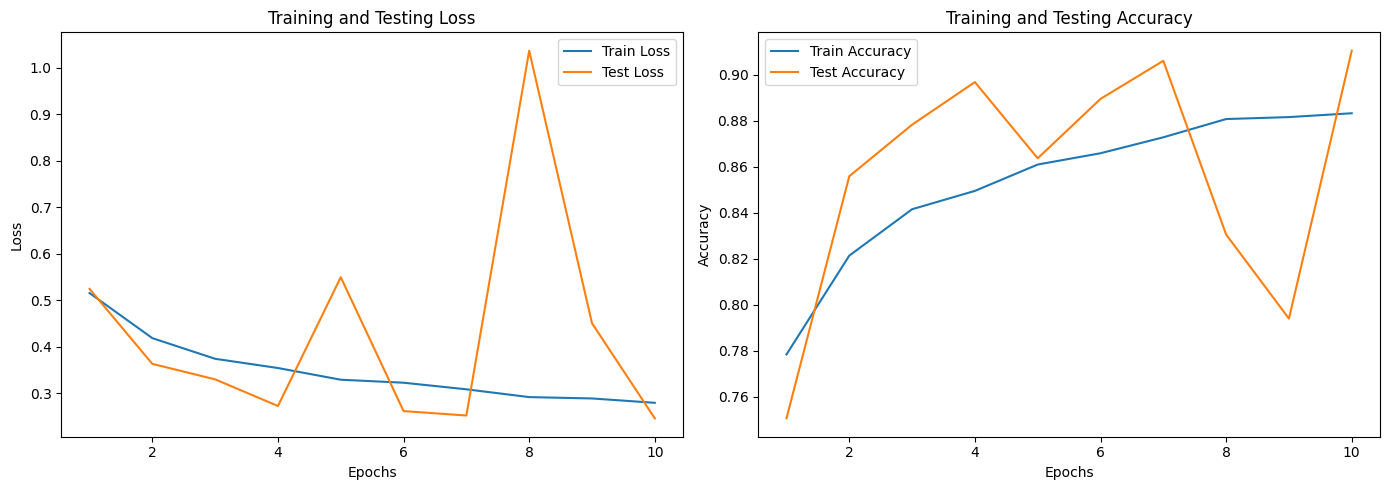

In [22]:
import matplotlib.pyplot as plt

train_losses, test_losses = zip(*history)
train_accuracies, test_accuracies = zip(*accuracy)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#### <b>(Option) Load the Pre-trained Original Model</b>

* We can easily download the pre-trained original model, rather than training the original model from scratch.
* <b>Download Link</b>:
    * gender: https://drive.google.com/file/d/1BzvUyFBHWQpTseBY8N6GaT1RrlhiTgZp/view?usp=drive_link
    * young: https://drive.google.com/file/d/15BmYjzvXs_57BcvN6haAgWJ2fYdSZfjW/view?usp=drive_link
    * smiling: https://drive.google.com/file/d/1lr0ozk9AUzm9ybqMbT7ixGnRdDrOUqhe/view?usp=drive_link

In [124]:
# male vs female
# !gdown https://drive.google.com/uc?id=1BzvUyFBHWQpTseBY8N6GaT1RrlhiTgZp -O pre_trained_checkpoint.pth

Downloading...
From: https://drive.google.com/uc?id=1BzvUyFBHWQpTseBY8N6GaT1RrlhiTgZp
To: /content/pre_trained_checkpoint.pth
100% 44.8M/44.8M [00:00<00:00, 186MB/s]


In [139]:
# young vs old
!gdown https://drive.google.com/uc?id=15BmYjzvXs_57BcvN6haAgWJ2fYdSZfjW -O pre_trained_checkpoint.pth

Downloading...
From: https://drive.google.com/uc?id=15BmYjzvXs_57BcvN6haAgWJ2fYdSZfjW
To: /content/pre_trained_checkpoint.pth
100% 44.8M/44.8M [00:00<00:00, 90.4MB/s]


In [82]:
# smiling vs unsmiling
# !gdown https://drive.google.com/uc?id=1lr0ozk9AUzm9ybqMbT7ixGnRdDrOUqhe -O pre_trained_checkpoint.pth

Downloading...
From: https://drive.google.com/uc?id=1lr0ozk9AUzm9ybqMbT7ixGnRdDrOUqhe
To: /content/pre_trained_checkpoint.pth
100% 44.8M/44.8M [00:00<00:00, 270MB/s]


<b>Final Test</b>

In [23]:
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.cuda()
# model_path = f'last_checkpoint_epoch_{num_original_epochs}_gender.pth' # If you trian the original model from scratch.
model_path = f'pre_trained_checkpoint.pth'  # downloaded model
model.load_state_dict(torch.load(model_path))

test_loss, test_acc = test(model, test_dataloader)
print("test loss:", test_loss)
print("test acc:", test_acc)

[Test]
[Batch: 1] running test loss: 0.2548, running test accuracy: 0.9062
[Batch: 20] running test loss: 0.2351, running test accuracy: 0.9055
test loss: 0.2339, accuracy: 0.9084
elapsed time: 7.59802770614624
test loss: 0.23394584203573535
test acc: 0.9084266926449099


#### <b> Train the "Retrained Model"</b>
* A model trained on only the retain dataset from scratch, excluding the forget dataset.
* This model can serve as a proxy ground-truth for calculating the potential ground-truth (1) model utility and (2) forgetting score.

In [24]:
retrained_model = models.resnet18(pretrained=False)
num_features = retrained_model.fc.in_features
retrained_model.fc = nn.Linear(num_features, 2)
retrained_model = retrained_model.cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(retrained_model.parameters(), lr=0.001)

In [25]:
learning_rate = 0.01
best_test_acc = 0
best_epoch = 0

history = []
accuracy = []
num_original_epochs = 10
for epoch in range(num_original_epochs):
    train_loss, train_acc = train(retrained_model, retain_dataloader_train)
    test_loss, test_acc = test(retrained_model, test_dataloader)
    history.append((train_loss, test_loss))
    accuracy.append((train_acc, test_acc))

[Epoch: 1 - Training]
[Batch: 20] running train loss: 0.5818, running train accuracy: 0.7516
[Batch: 40] running train loss: 0.5703, running train accuracy: 0.7555
[Batch: 60] running train loss: 0.5710, running train accuracy: 0.7534
[Batch: 80] running train loss: 0.5624, running train accuracy: 0.7580
[Batch: 100] running train loss: 0.5600, running train accuracy: 0.7581
[Batch: 120] running train loss: 0.5573, running train accuracy: 0.7583
[Batch: 140] running train loss: 0.5584, running train accuracy: 0.7574
[Batch: 160] running train loss: 0.5577, running train accuracy: 0.7561
[Batch: 180] running train loss: 0.5575, running train accuracy: 0.7554
[Batch: 200] running train loss: 0.5568, running train accuracy: 0.7553
[Batch: 220] running train loss: 0.5580, running train accuracy: 0.7536
[Batch: 240] running train loss: 0.5583, running train accuracy: 0.7525
train loss: 0.5583, accuracy: 0.7523
elapsed time: 61.229525327682495
[Test]
[Batch: 1] running test loss: 0.5097, run

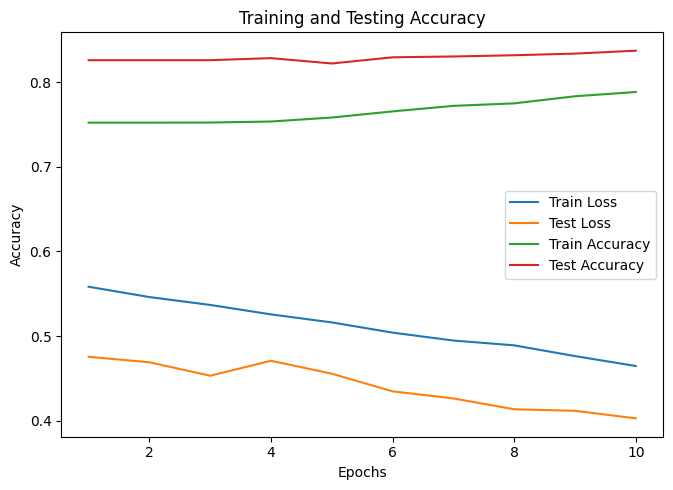

In [26]:
import matplotlib.pyplot as plt

train_losses, test_losses = zip(*history)
train_accuracies, test_accuracies = zip(*accuracy)

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & testing accuracieplt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
test_acc = evaluation(retrained_model, test_dataloader)
unseen_acc = evaluation(retrained_model, unseen_dataloader)
mia = cal_mia(retrained_model.cuda())
print()
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')


Test Acc: {'Loss': 0.403, 'Acc': 0.8373112518265953}
Unseen Acc: {'Loss': 0.457, 'Acc': 0.7981009495252374}
MIA: {'MIA': 0.545635910224439, 'Forgeting Score': 0.045635910224439025}
Final Score: 0.8730197156888586
